Raster Reclassfication
Here, is a method which is used to change raster values into different ones, to fit the data.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


Importing the same data as before.

In [2]:
# Define relative paths to DTM and DSM files
dtm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM files
with rio.open(dtm_path) as src:
    lidar_dtm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

with rio.open(dsm_path) as src:
    lidar_dsm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

# Create canopy height model (CHM)    
lidar_chm_im = lidar_dsm_im - lidar_dtm_im
lidar_chm_im


masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

This is just rebuilding some of the files needed from the previous project. It may not be necessary, but I'd rather not take a chance.

In [3]:
# View min and max values in the data
print('CHM min value:', lidar_chm_im.min())
print('CHM max value:', lidar_chm_im.max())


CHM min value: 0.0
CHM max value: 26.930054


Finding bounds of data, as before.

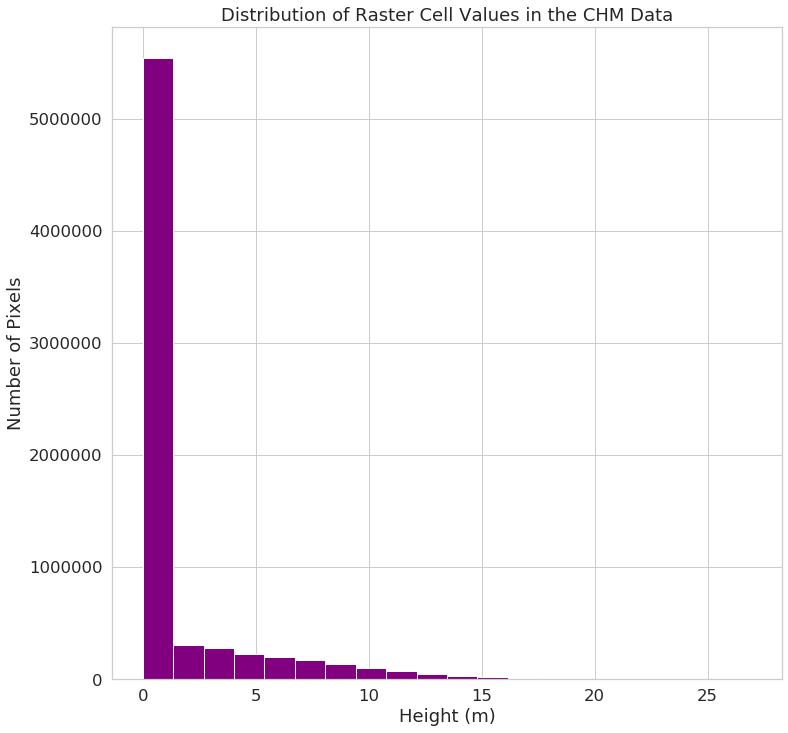

In [4]:
ep.hist(lidar_chm_im.ravel(),
        title="Distribution of Raster Cell Values in the CHM Data",
        xlabel="Height (m)",
        ylabel="Number of Pixels")

plt.show()


This is the histogram, looking at pixel v height. This tapers off dramatically.

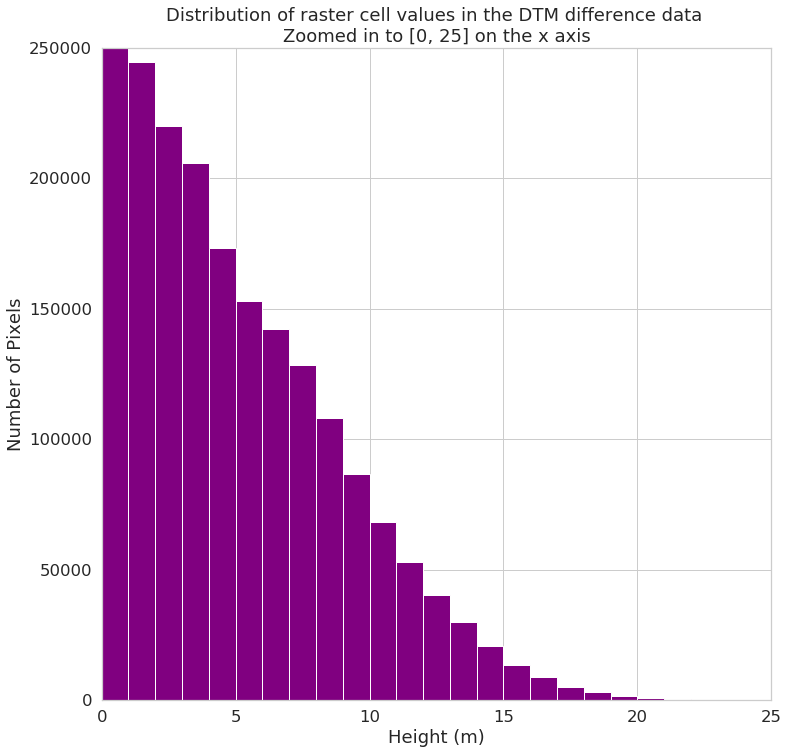

In [5]:
xlim = [0, 25]

f, ax = ep.hist(lidar_chm_im.ravel(),
                hist_range=xlim,
                bins=range(*xlim),
                ylabel="Number of Pixels", xlabel="Height (m)",
                title="Distribution of raster cell values in the DTM difference data \n" +
                      "Zoomed in to {} on the x axis".format(xlim))

ax.set(xlim=xlim, ylim=[0, 250000])

plt.show()

This is a zoomed in version of the previous graph, looking at about a 20 times zoom on the y axis.

In [6]:

counts, bins = np.histogram(lidar_chm_im,
                            bins=50,
                            range=xlim)

print("counts:", counts)
print("bins:", bins)


counts: [5292785  155317  128037  116551  109743  110395  107528   98579   89234
   83947   79123   73934   71669   70521   67043   61639   56389   51932
   46193   40674   36442   31877   28428   24553   21620   18613   16095
   13776   11424    9402    7504    6195    4883    3901    2954    2306
    1776    1342    1027     706     525     358     271     160     113
      99      47      44      21      16]
bins: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25. ]


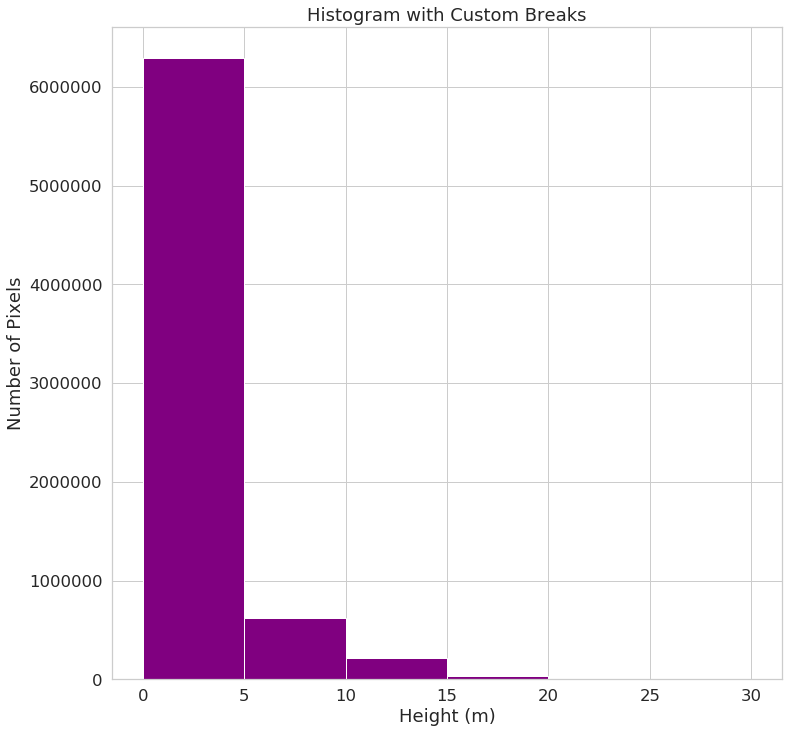

In [7]:
ep.hist(lidar_chm_im.ravel(),
        bins=[0, 5, 10, 15, 20, 30],
        title="Histogram with Custom Breaks",
        xlabel="Height (m)",
        ylabel="Number of Pixels")

plt.show()

These two images are other variations onthe original histogram. The first is looking at some of the data that python used to draw, while the second redefines the bins,

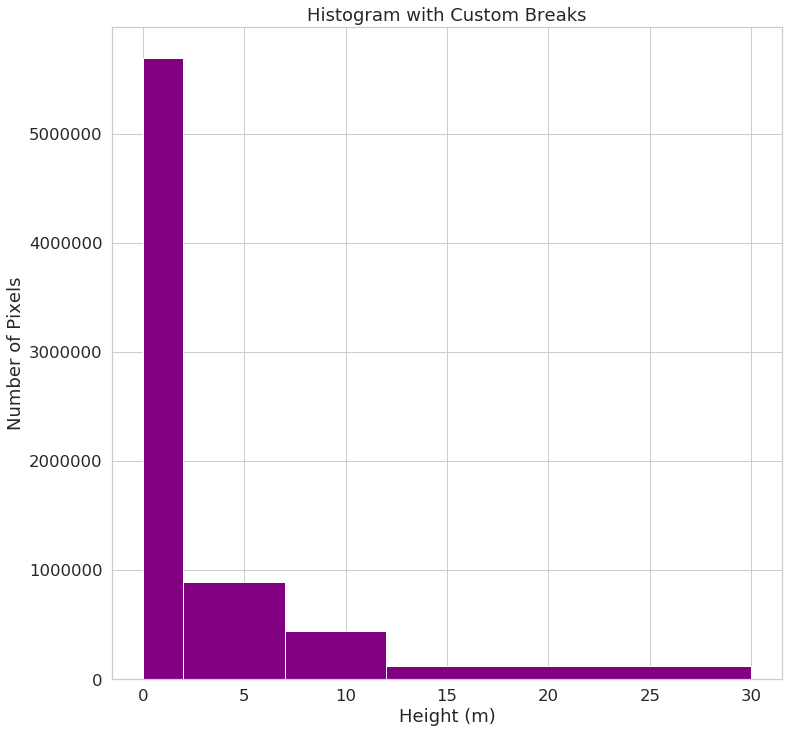

In [8]:
ep.hist(lidar_chm_im.ravel(),
        colors='purple',
        bins=[0, 2, 7, 12, 30],
        title="Histogram with Custom Breaks",
        xlabel="Height (m)",
        ylabel="Number of Pixels")

plt.show()


This is another histogram, this time using a range of values for the bins. (such as 'large trees', which is all trees with a height greater that 12m)

In [9]:
class_bins = [lidar_chm_im.min(), 2, 7, 12, np.iinfo(np.int32).max]

# Classify the original image array, then unravel it again for plotting
lidar_chm_im_class = np.digitize(lidar_chm_im, class_bins)

# Note that you have an extra class in the data (0)
print(np.unique(lidar_chm_im_class))

[0 1 2 3 4]


In [10]:
type(lidar_chm_im_class)


numpy.ndarray

In [11]:
lidar_chm_class_ma = np.ma.masked_where(lidar_chm_im_class == 0,
                                        lidar_chm_im_class,
                                        copy=True)
lidar_chm_class_ma

masked_array(
  data=[[--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        ...,
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1],
        [--, --, --, ..., 1, 1, 1]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=999999)

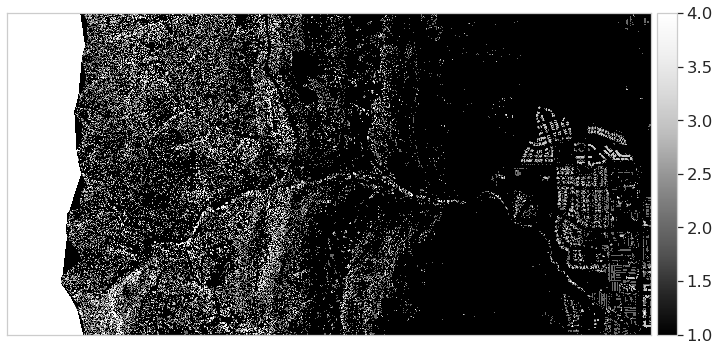

In [12]:
ep.plot_bands(lidar_chm_class_ma,
              scale=False)
plt.show()


These code blocks were designed to change the raster map from its previous form into something more similar to the histogram shown above, with a group of 4 bins. In doing so, the raster has a very different scale used. Using the following code to change to change the color.

In [13]:

np.unique(lidar_chm_class_ma)


masked_array(data=[1, 2, 3, 4, --],
             mask=[False, False, False, False,  True],
       fill_value=999999)

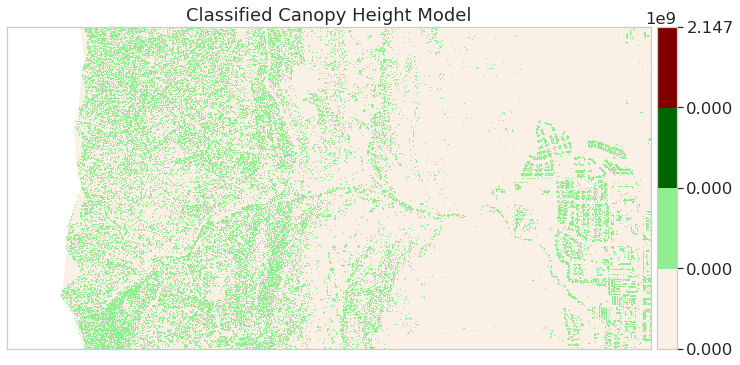

In [14]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, len(colors))

ep.plot_bands(lidar_chm_class_ma,
              cmap=cmap,
              title="Classified Canopy Height Model",
              scale=False,
              norm=norm)
plt.show()



At this point the raster emphasizes all the significant heights in the region.

In [15]:

np.unique(lidar_chm_class_ma)

masked_array(data=[1, 2, 3, 4, --],
             mask=[False, False, False, False,  True],
       fill_value=999999)

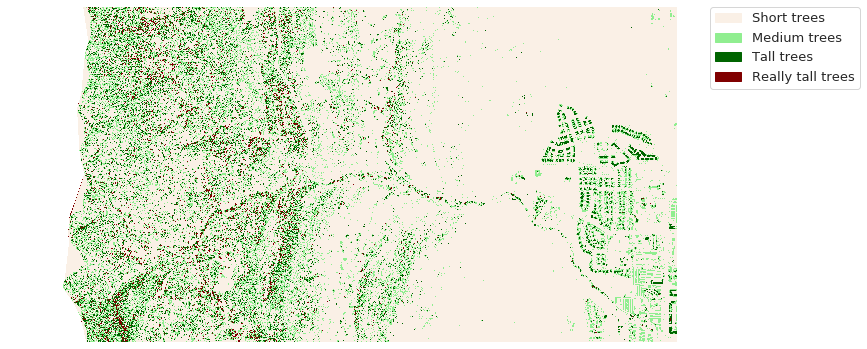

In [16]:
height_class_labels = ["Short trees", "Medium trees",
                       "Tall trees", "Really tall trees"]

# Create a colormap from a list of colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
cmap = ListedColormap(colors)

f, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(lidar_chm_class_ma,
               cmap=cmap)

ep.draw_legend(im, titles=height_class_labels)
ax.set_axis_off()

plt.show()

The previous two blocks add a legend to the raster, instead of the previous 4 point color scale, as shown above.